In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [36]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures/MBL"

In [37]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [38]:
def set_size(width='thesis', fraction=1, subplots=(1, 1),aspect_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [39]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [40]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [41]:
def model(x,a,b):
    return a*x**b
def modelnn(x,a,b):
    return 2-a*x**(-b)

In [42]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"xx/h = 0",datapath/"xx/h = 3",datapath/"xx/h = 6",datapath/"xx/h = 9",datapath/"xx/h = 12",datapath/"xx/h = 24",datapath/"xx/h = 50",datapath/"xx/h = 75",datapath/"xx/h = 24 ext"]
files = ["combined_file_h{}.jld2".format(h) for h in [0,3,6,9,12,24,50,75,24]] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])
folders_nn = [datapath/"xx_nn/h = 0",datapath/"xx_nn/h = 3",datapath/"xx_nn/h = 6",datapath/"xx_nn/h = 9",datapath/"xx_nn/h = 12",datapath/"xx_nn/h = 24", datapath/"xx_nn/h = 50",datapath/"xx_nn/h = 75",datapath/"xx_nn/h = 24 ext"]
files_nn = ["combined_file_h{}.jld2".format(h) for h in [0,3,6,9,12,24,50,75,24]] 
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

/tmp/ipykernel_70481/2086647423.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
/tmp/ipykernel_70481/2086647423.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))


In [43]:
N = 13
hs = [0,3,6,9,12,24]
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [44]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

/home/qd/python-envs/max1/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/qd/python-envs/max1/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [45]:
for i in range(len(files)):
    print(data[i].shape[2],"  nn ",data_nn[i].shape[2],"\n")

1   nn  1 

500   nn  500 

500   nn  500 

500   nn  500 

500   nn  500 

500   nn  500 

125   nn  125 

125   nn  125 

6000   nn  6000 



# Disorder Average

In [46]:
popt = []
perr = []
tfitmax = [75,65,60,53,38]
tfitmin = [50,44,40,33,33]
for j in range(5):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red[-1][tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [47]:
popt

[array([0.04354337, 0.42385322]),
 array([0.05780501, 0.44752204]),
 array([0.12555006, 0.41807483]),
 array([0.25026788, 0.42552992]),
 array([0.6554715 , 0.52438918])]

In [48]:
def modelnn2(x,a,b):
    return 2-a*np.exp(-b*x)
def modelnn3(x,b,c):
    return 2*(1-np.exp(-(b*x)**c))

In [49]:
popt_nn = []
perr_nn = []
tfitmax = [100,100,100,100,100]
tfitmin = [0,0,0,0,0]
for j in range(5):
    poptj, pcovj = curve_fit(modelnn3,T[tfitmin[j]:tfitmax[j]],red_nn[-1][tfitmin[j]:tfitmax[j],j])
    popt_nn.append(poptj)
    perr_nn.append(np.sqrt(np.diag(pcovj)))

/tmp/ipykernel_70481/2148330282.py:4: RuntimeWarning: invalid value encountered in power
  return 2*(1-np.exp(-(b*x)**c))


In [50]:
popt_nn

[array([2.20019723e-05, 3.15183975e-01]),
 array([6.90133654e-05, 3.21118594e-01]),
 array([0.0005214 , 0.34883862]),
 array([0.00683031, 0.42720591]),
 array([0.13750552, 0.64210475])]

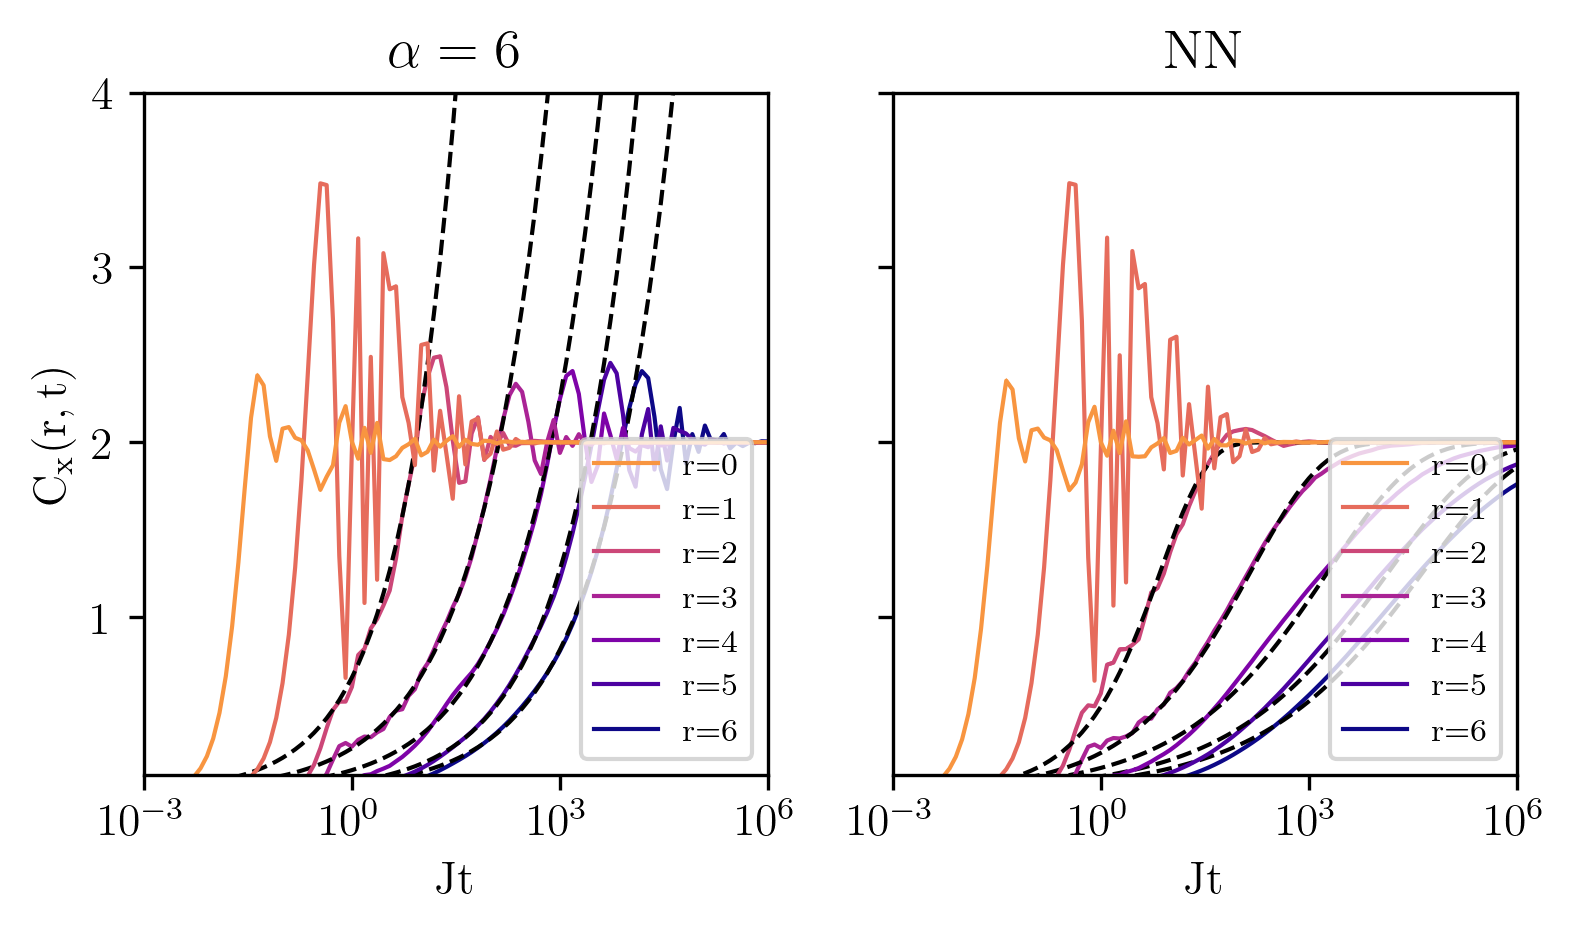

In [51]:
fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0].plot(T,red[-1][:,j],label="r={}".format(rvals[j]),lw=1)
    if j<=4:
        axs[0].plot(T[tfitmin[j]:tfitmax[j]],model(T[tfitmin[j]:tfitmax[j]],*popt[j]),c="black",ls="dashed",lw=1)
    axs[0].fill_between(T, red[-1][:,j]-red_sem[-1][:,j], red[-1][:,j]+red_sem[-1][:,j])

handles, labels = axs[0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")
axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title(r"$\alpha = 6$")
axs[0].set_xlim(1e-3,1e6)
axs[0].set_ylim(1e-1,4)
#axs[0].set_yscale("log")


axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1].plot(T,red_nn[-1][:,j],label="r={}".format(rvals[j]),lw=1)
    if j<=4:
        axs[1].plot(T[tfitmin[j]:tfitmax[j]],modelnn3(T[tfitmin[j]:tfitmax[j]],*popt_nn[j]),c="black",ls="dashed",lw=1)
    axs[1].fill_between(T, red_nn[-1][:,j]-red_sem_nn[-1][:,j], red_nn[-1][:,j]+red_sem_nn[-1][:,j])

handles, labels = axs[1].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")
axs[1].set_xlabel(r"Jt")
axs[1].set_title("NN")
axs[1].set_xlim(1e-3,1e6)
axs[1].set_ylim(1e-1,4)
#axs[1].set_yscale("log")



plt.savefig(figurepath/"disorder_fits_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

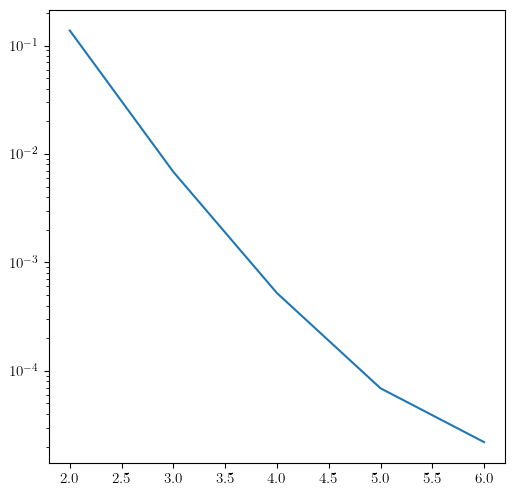

In [52]:
plt.plot(rvals[0:len(popt_nn)],[popt_nn[j][0] for j in range(len(popt_nn))])
plt.yscale("log")

# Typical Curves

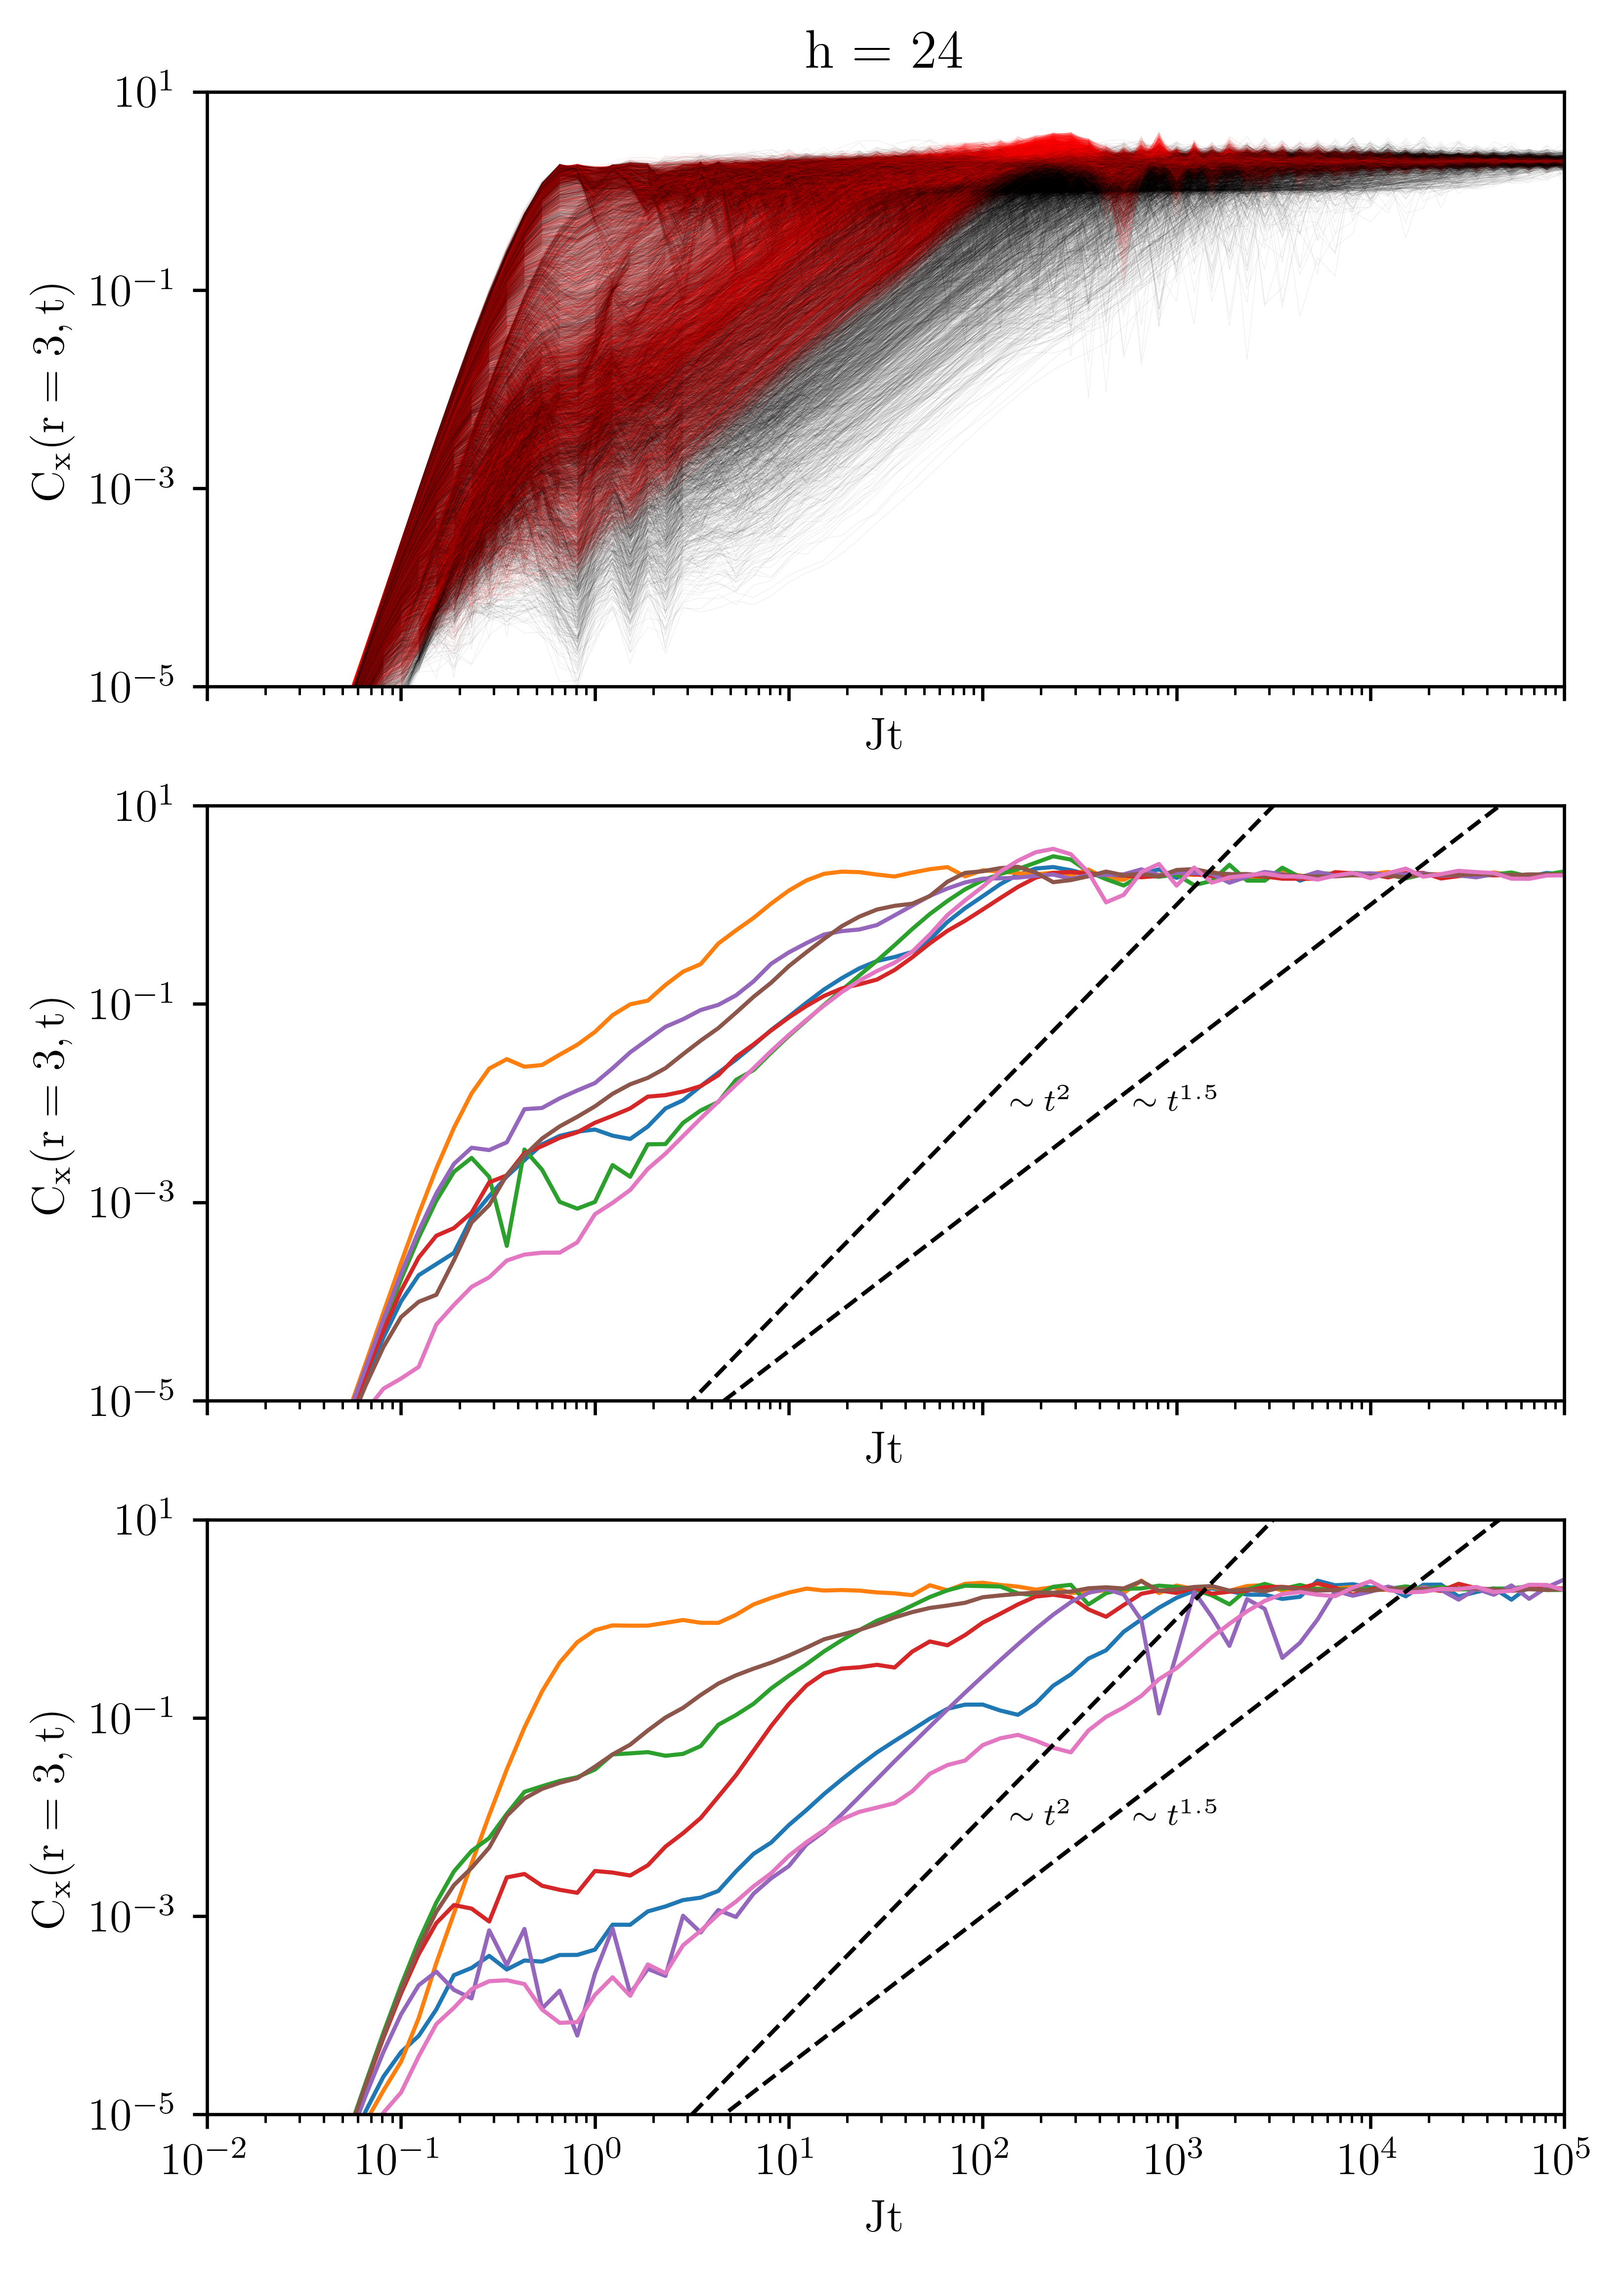

In [53]:
fig,axs = plt.subplots(3,1,figsize=set_size(aspect_ratio=0.5,subplots=(3,1)),dpi=600,sharex=True)

SHOTS = range(0,6000)
SHOTS_pl = [2,136,499,1863,1969,1995,2022]
SHOTS_nn = [3,24,28,40,136,499,1]

j = 3

axs[0].set_xscale("log")
axs[0].set_yscale("log")
for s in SHOTS:
    axs[0].plot(T,data[-1][:,j,s],label="r={}".format(rvals[j]),lw=0.1,c="red",alpha=0.1)
    axs[0].plot(T,data_nn[-1][:,j,s],label="r={}".format(rvals[j]),lw=0.1,c="black",alpha=0.1)

axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_x(r=3,t)}$")
axs[0].set_title("h = {}".format(hs[-1]))
axs[0].set_xlim(1e-2,1e6)
axs[0].set_ylim(1e-5,1e1)



axs[1].set_xscale("log")
axs[1].set_yscale("log")
for s in SHOTS_pl:
    axs[1].plot(T,data[-1][:,j,s],lw=1)

axs[1].plot(T,1e6*T**1.5/1e12,c="black",ls="dashed",lw=1)
axs[1].plot(T,1e6*T**2/1e12,c="black",ls="dashed",lw=1)

axs[1].set_xlabel(r"Jt")
axs[1].set_ylabel(r"$\mathrm{C_x(r=3,t)}$")
axs[1].set_xlim(1e-2,1e5)
axs[1].set_ylim(1e-5,1e1)
axs[1].text(200,1e-2,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")
axs[1].text(1000,1e-2,r"$\sim t^{1.5}$",ha="center",va="center",fontsize="x-small")


axs[2].set_xscale("log")
axs[2].set_yscale("log")
for s in SHOTS_nn:
    axs[2].plot(T,data_nn[-1][:,j,s],lw=1)

axs[2].plot(T,1e6*T**1.5/1e12,c="black",ls="dashed",lw=1)
axs[2].plot(T,1e6*T**2/1e12,c="black",ls="dashed",lw=1)

axs[2].set_xlabel(r"Jt")
axs[2].set_ylabel(r"$\mathrm{C_x(r=3,t)}$")
axs[2].set_xlim(1e-2,1e5)
axs[2].set_ylim(1e-5,1e1)
axs[2].text(200,1e-2,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")
axs[2].text(1000,1e-2,r"$\sim t^{1.5}$",ha="center",va="center",fontsize="x-small")

plt.savefig(figurepath/"typical_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Probability Distributions

In [54]:
Nbins = 50
probabilities = np.zeros((Nbins-1,len(T),N//2+1))
bin_edges = np.linspace(0,3,Nbins)
l = bin_edges[1]-bin_edges[0]
for Ti in range(len(T)):
    for j in range(N//2+1):
        probabilities[:,Ti,j],x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers

In [55]:
probabilities_nn = np.zeros((Nbins-1,len(T),N//2+1))
bin_edges = np.linspace(0,3,Nbins)
l = bin_edges[1]-bin_edges[0]
for Ti in range(len(T)):
    for j in range(N//2+1):
        probabilities_nn[:,Ti,j],x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers

# Overlaid Plots

In [56]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 6,                   # Set font size to 11pt
    'axes.labelsize': 6,               # -> axis labels
    'legend.fontsize': 5,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

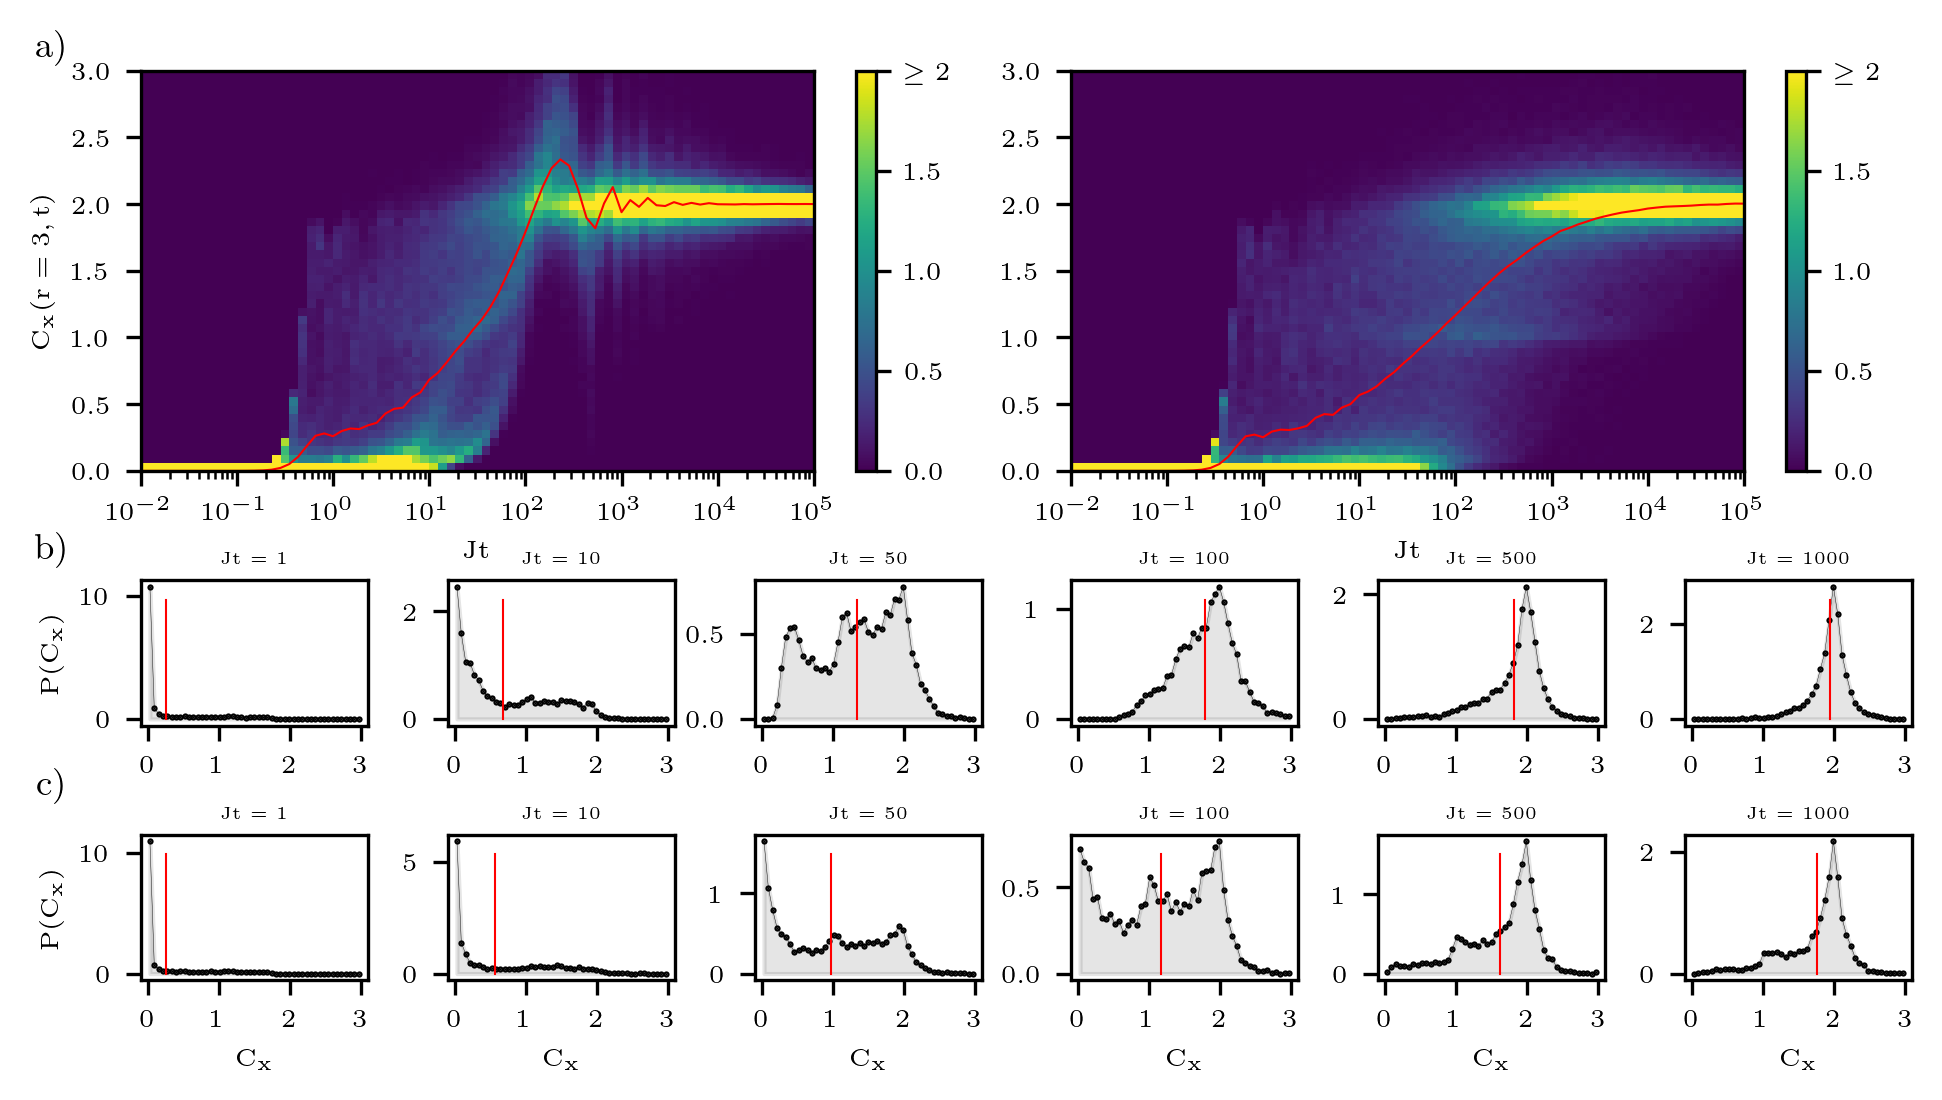

In [57]:
fig = plt.figure(figsize = set_size(subplots=(4,6)),dpi = 300)
gs1 = gridspec.GridSpec(4, 3,figure=fig)
gs1.update(left=0.0, right = 0.475, wspace = 0.35, hspace=0.75)
gs2 = gridspec.GridSpec(4, 3,figure=fig)
gs2.update(left=0.525, right = 1.0, wspace = 0.35, hspace=0.75)

j = 3

ax1 = plt.subplot(gs1[0:2, 0:3])
ax2 = plt.subplot(gs2[0:2, 0:3])

ax3 = plt.subplot(gs1[2, 0])
ax4 = plt.subplot(gs1[2, 1])
ax5 = plt.subplot(gs1[2, 2])
ax6 = plt.subplot(gs2[2, 0])
ax7 = plt.subplot(gs2[2, 1])
ax8 = plt.subplot(gs2[2, 2])
ax9 = plt.subplot(gs1[3, 0])
ax10 = plt.subplot(gs1[3, 1])
ax11 = plt.subplot(gs1[3, 2])
ax12 = plt.subplot(gs2[3, 0])
ax13 = plt.subplot(gs2[3, 1])
ax14 = plt.subplot(gs2[3, 2])

bin_edges1 = np.linspace(0,3,Nbins)

ax1.set_xscale("log")
ax1.plot(T,red[-1][:,j],lw=0.5,c="red")
ax1.fill_between(T, red[-1][:,j]-red_sem[-1][:,j], red[-1][:,j]+red_sem[-1][:,j])

ax1.set_ylabel(r"$\mathrm{C_x(r=3,t)}$")
ax1.set_xlim(1e-2,1e5)
ax1.set_ylim(0,3.0)
im1 = ax1.pcolormesh(np.concatenate(([0],T)),bin_edges1,probabilities[:,:,j],cmap="viridis",vmin=0,vmax=2)
ax1.set_xlabel("Jt")

ax_cb1 = fig.colorbar(im1, ax=ax1, ticks=[0,0.5,1,1.5,2]).ax
ax_cb1.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])


ax2.set_xscale("log")
ax2.plot(T,red_nn[-1][:,j],lw=0.5,c="red")
ax2.fill_between(T, red_nn[-1][:,j]-red_sem_nn[-1][:,j], red_nn[-1][:,j]+red_sem_nn[-1][:,j])

ax2.set_xlim(1e-2,1e5)
ax2.set_ylim(0,3.0)
im2 = ax2.pcolormesh(np.concatenate(([0],T)),bin_edges1,probabilities_nn[:,:,j],cmap="viridis",vmin=0,vmax=2)
ax2.set_xlabel("Jt")

ax_cb2 = fig.colorbar(im2, ax=ax2, ticks=[0,0.5,1,1.5,2]).ax
ax_cb2.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])

Nbins2 = 50
ts_pl = [1,10,50,100,500,1000]
i = 0
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax3.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax3.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax3.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax3.set_xlim(0-0.1,3.1)
ax3.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax3.set_ylabel(r"$\mathrm{P(C_x)}$")
ax3.set_xticks([0,1,2,3])
#ax3.set_ylim(-0.05,p.max()*1.1)


i = 1
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax4.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax4.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax4.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax4.set_xlim(0-0.1,3.1)
ax4.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax4.set_xticks([0,1,2,3])
#ax4.set_ylim(-0.05,p.max()*1.1)


i = 2
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax5.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax5.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax5.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax5.set_xlim(0-0.1,3.1)
ax5.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax5.set_xticks([0,1,2,3])
#ax5.set_ylim(-0.05,p.max()*1.1)


i = 3
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax6.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax6.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax6.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax6.set_xlim(0-0.1,3.1)
ax6.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax6.set_xticks([0,1,2,3])
#ax6.set_ylim(-0.05,p.max()*1.1)


i = 4
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax7.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax7.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax7.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax7.set_xlim(0-0.1,3.1)
ax7.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax7.set_xticks([0,1,2,3])
#ax7.set_ylim(-0.05,p.max()*1.1)


i = 5
Ti = np.argmin(np.abs(T-ts_pl[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax8.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data[-1][Ti,j,:])
ax8.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax8.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax8.set_xlim(0-0.1,3.1)
ax8.text(1.5,p.max()*1.2,"Jt = {}".format(ts_pl[i]),ha="center",va="center",fontsize="x-small")
ax8.set_xticks([0,1,2,3])
#ax8.set_ylim(-0.05,p.max()*1.1)



ts_nn = [1,10,50,100,500,1000]
i = 0
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax9.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax9.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax9.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax9.set_xlim(0-0.1,3.1)
ax9.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax9.set_ylabel(r"$\mathrm{P(C_x)}$")
ax9.set_xlabel(r"$\mathrm{C_x}$")
ax9.set_xticks([0,1,2,3])
#ax9.set_ylim(-0.05,p.max()*1.1)


i = 1
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax10.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax10.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax10.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax10.set_xlim(0-0.1,3.1)
ax10.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax10.set_xlabel(r"$\mathrm{C_x}$")
ax10.set_xticks([0,1,2,3])
#ax10.set_ylim(-0.05,p.max()*1.1)


i = 2
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax11.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax11.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax11.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax11.set_xlim(0-0.1,3.1)
ax11.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax11.set_xlabel(r"$\mathrm{C_x}$")
ax11.set_xticks([0,1,2,3])
#ax11.set_ylim(-0.05,p.max()*1.1)


i = 3
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax12.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax12.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax12.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax12.set_xlim(0-0.1,3.1)
ax12.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax12.set_xlabel(r"$\mathrm{C_x}$")
ax12.set_xticks([0,1,2,3])
#ax12.set_ylim(-0.05,p.max()*1.1)


i = 4
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax13.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax13.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax13.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax13.set_xlim(0-0.1,3.1)
ax13.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax13.set_xlabel(r"$\mathrm{C_x}$")
ax13.set_xticks([0,1,2,3])
#ax13.set_ylim(-0.05,p.max()*1.1)


i = 5
Ti = np.argmin(np.abs(T-ts_nn[i]))
bin_edges = np.linspace(0,3,Nbins2)
p,x = np.histogram(data_nn[-1][Ti,j,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
ax14.plot(x,p,marker="o",lw=0.1,ms=0.5,c="black")
mean = np.mean(data_nn[-1][Ti,j,:])
ax14.plot([mean,mean],[0,p.max()*0.9],c="red",lw=0.5)
ax14.fill_between(x,np.zeros(Nbins2-1),p,alpha=0.1,color="black")
ax14.set_xlim(0-0.1,3.1)
ax14.text(1.5,p.max()*1.2,"Jt = {}".format(ts_nn[i]),ha="center",va="center",fontsize="x-small")
ax14.set_xlabel(r"$\mathrm{C_x}$")
ax14.set_xticks([0,1,2,3])
#ax14.set_ylim(-0.05,p.max()*1.1)

plt.gcf().text(-0.05,0.9,"a)",ha="center",va="center",fontsize="x-large")
plt.gcf().text(-0.05,0.475,"b)",ha="center",va="center",fontsize="x-large")
plt.gcf().text(-0.05,0.275,"c)",ha="center",va="center",fontsize="x-large")


plt.savefig(figurepath/"evolution_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Light Cones - not to be used

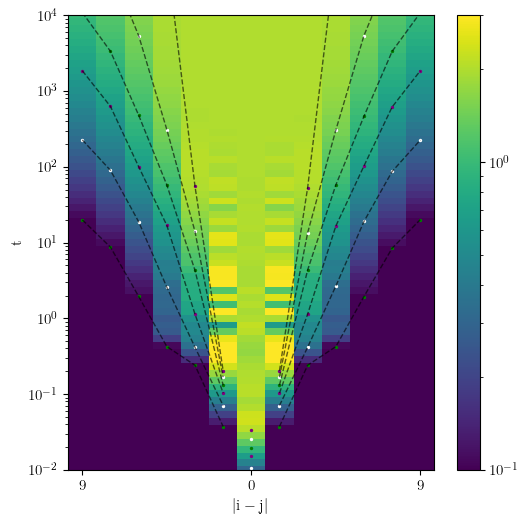

In [436]:
res_safe = np.clip(res_nn[-1],1e-14,3)
thresholds = [0.1,0.33,0.66,1,1.5,2]

fit_params = []
fit_errs = []
tvals = []
masks = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res_safe,th))
    masks.append(np.isfinite(tvals[i])) 
    popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2


fig = plt.figure(figsize = set_size())
ax1 = fig.add_subplot(111)
pcm = ax1.pcolormesh(range(0,N),T,res_safe,cmap="viridis",norm=colors.LogNorm(vmin=1e-1,vmax=res_safe.max()))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    ax1.plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    ax1.scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 2)
# ax1.scatter(np.arange(0,8,1),tcut_zz,marker="o",color="red",s=2)
# ax1.scatter(np.arange(8+3,N,1),np.flip(tcut_zz),marker="o",color="red",s=2)
fig.colorbar(pcm,ax=ax1)
ax1.set_xlabel(r"$\mathrm{|i-j|}$")
ax1.set_xticks([0,N//2,N-1])
ax1.set_xticklabels([9,0,9])
ax1.set_yscale("log")
ax1.set_ylabel("t")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax1.set_ylim(1e-2,1e4)
plt.show()

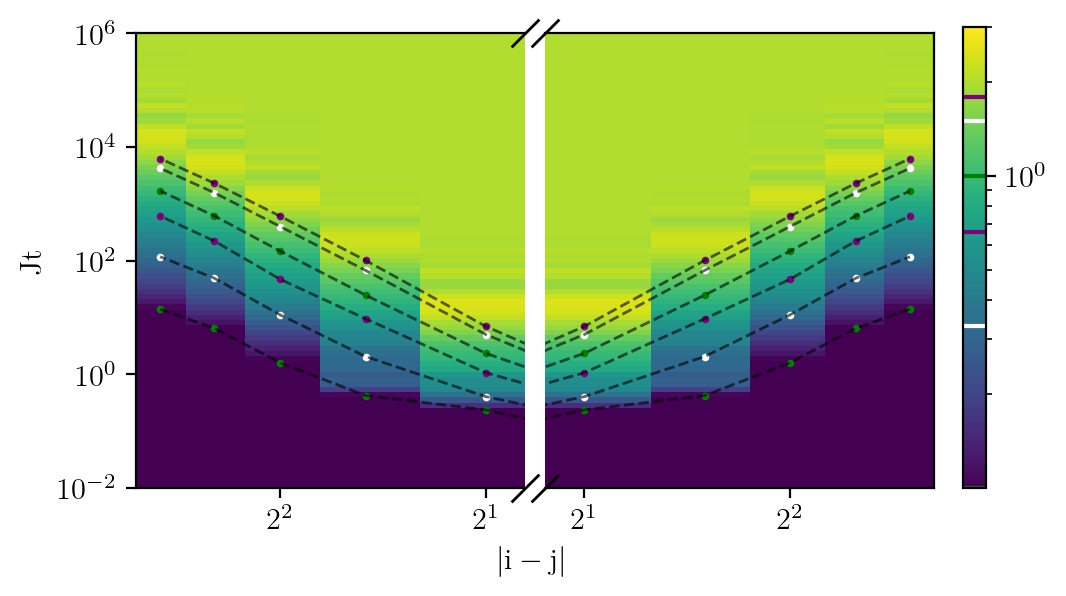

In [437]:
res_safe = np.clip(res[-1],1e-14,3)
thresholds = [0.1,0.33,0.66,1,1.5,1.8]

fit_params = []
fit_errs = []
tvals = []
masks = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res_safe,th))
    masks.append(np.isfinite(tvals[i])) 
    popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig, axes = plt.subplots(1,2,figsize = set_size(subplots=(1,2)),dpi=200)
ax1 = axes[0]
ax2 = axes[1]


ax1.pcolormesh(rvals[N//2+1:],T,res_safe[:,N//2+1:],cmap="viridis",norm=colors.LogNorm(vmin=1e-1,vmax=res_safe.max()))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    ax1.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    ax1.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = mcolors2[i], s = 3)
#ax1.scatter(rvals[N//2+2:],np.flip(tcut_zz),marker="o",color="red",s=3)
ax1.invert_xaxis()

ax1.set_xscale("log",base=2)
ax1.set_xlim(N//2+0.5,2-0.25)
#ax1.set_xticks([0,N//2,N-1])
#ax1.set_xticklabels([9,0,9])
ax1.set_yscale("log")
ax1.set_ylabel("Jt")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax1.set_ylim(1e-2,1e6)



pcm = ax2.pcolormesh(rvals[N//2+1:],T,res_safe[:,N//2+1:],cmap="viridis",norm=colors.LogNorm(vmin=1e-1,vmax=res_safe.max()))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    ax2.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    ax2.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = mcolors2[i], s = 3)
#ax2.scatter(rvals[N//2+2:],np.flip(tcut_zz),marker="o",color="red",s=3)

ax2.set_xscale("log",base=2)
ax2.set_xlim(2-0.25,N//2+0.5)
#ax1.set_xticks([0,N//2,N-1])
#ax1.set_xticklabels([9,0,9])
ax2.set_yscale("log")
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticks([], minor=True)
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax2.set_ylim(1e-2,1e6)


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[1e-14,1e-11,1e-8,1e-5,1e-2,1e0]).ax
cbar_ax.set_visible(False)
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])
cbar.plot([0,1],[thresholds[3]]*2,c=mcolors2[3])
cbar.plot([0,1],[thresholds[4]]*2,c=mcolors2[4])
cbar.plot([0,1],[thresholds[5]]*2,c=mcolors2[5])



ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)


d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.text(1.025,-0.16,r"$\mathrm{|i-j|}$",ha="center",va="center",transform=ax1.transAxes)#,fontsize="xx-small")
plt.subplots_adjust(wspace=0.05)

#plt.savefig(figurepath/"lc_regimes.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()